In [1]:
#import libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
#create an engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#create inspector
inspector = inspect(engine)

In [4]:
#find the names of the tables
inspector.get_table_names()

['measurement', 'station']

In [5]:
#find the names of columns in the measurement table
Mcolumns = inspector.get_columns('measurement')
for column in Mcolumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
#find the names of columns in the station table
Scolumns = inspector.get_columns('station')
for column in Scolumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
#create base
Base = automap_base()

In [8]:
#prepare base
Base.prepare(engine, reflect=True)

In [9]:
#get the names of the classes
Base.classes.keys()

['measurement', 'station']

In [10]:
#instantiate classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
#start session
session = Session(engine)

In [12]:
#find the last date with a measurement
last_measurement = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
for m in last_measurement:
    print(m.date)
    last_date=m.date

2017-08-23


In [13]:
#find the day a year before the last date
year_before = dt.date.isoformat(dt.date.fromisoformat(last_date)-dt.timedelta(days=365))
#query the measurements from the final year only
one_year = session.query(Measurement).filter(Measurement.date > year_before)
#print dates and precipitation for final year
for m in one_year:
    print(f"{m.date}  {m.prcp}")


2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.0
2016-08-27  0.0
2016-08-28  0.01
2016-08-29  0.0
2016-08-30  0.0
2016-08-31  0.13
2016-09-01  0.0
2016-09-02  0.0
2016-09-03  0.0
2016-09-04  0.03
2016-09-05  None
2016-09-06  None
2016-09-07  0.05
2016-09-08  0.0
2016-09-09  0.03
2016-09-10  0.0
2016-09-11  0.05
2016-09-12  0.0
2016-09-13  0.02
2016-09-14  1.32
2016-09-15  0.42
2016-09-16  0.06
2016-09-17  0.05
2016-09-18  0.0
2016-09-19  0.0
2016-09-20  0.0
2016-09-21  0.0
2016-09-22  0.02
2016-09-23  0.0
2016-09-24  0.0
2016-09-25  0.0
2016-09-26  0.06
2016-09-27  0.02
2016-09-28  0.0
2016-09-29  0.0
2016-09-30  0.0
2016-10-01  0.0
2016-10-02  0.0
2016-10-03  0.0
2016-10-04  0.0
2016-10-05  0.0
2016-10-06  0.0
2016-10-07  0.0
2016-10-08  0.0
2016-10-09  0.0
2016-10-10  0.0
2016-10-11  0.0
2016-10-12  0.0
2016-10-13  0.0
2016-10-14  0.0
2016-10-15  0.0
2016-10-16  0.0
2016-10-17  0.01
2016-10-18  0.0
2016-10-19  0.0
2016-10-20  0.0
2016-10-21  0.05
2016-10-22  0.15
2016-10-23  0.01
20

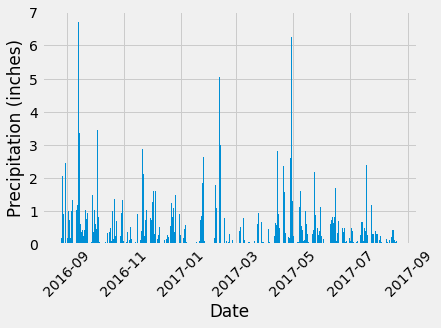

In [14]:
#make a dataframe from the final year's data
one_year_df = pd.read_sql("SELECT date, prcp FROM measurement WHERE date > '2016-08-23' ORDER BY date",engine)
#convert dates to dates
one_year_df["date"] = pd.to_datetime(one_year_df["date"],yearfirst=True)
#format graph
plt.xticks(rotation = 45)
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
#make plot
plt.bar(one_year_df["date"],one_year_df["prcp"])
#one_year_df.plot("date","prcp",kind="bar")
plt.show()

In [15]:
#summarize precipitation data
one_year_df["prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [16]:
#count stations
session.query(Station).count()

9

In [17]:
#find the most active station
activity = engine.execute("SELECT s.station, s.name, COUNT(m.prcp) FROM measurement m JOIN station s ON s.station = m.station GROUP BY s.station ORDER BY COUNT(m.prcp) DESC").fetchall()

In [18]:
#print the most active station
print(f"Station id {activity[0][0]} had the most observations.")

Station id USC00519281 had the most observations.


In [19]:
#find the highest temperature from the most active station
engine.execute("SELECT MAX(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()[0][0]

85.0

In [20]:
#find the lowest temperature from the most active station
engine.execute("SELECT MIN(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()[0][0]

54.0

In [21]:
#find the average temperature from the most active station
engine.execute("SELECT AVG(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()[0][0]

71.66378066378067

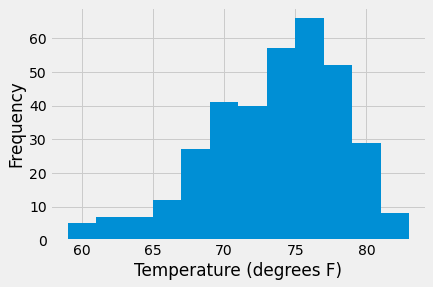

In [22]:
#get temperatures from most active station in final year
tobs = engine.execute("SELECT tobs FROM measurement WHERE station = 'USC00519281' AND date > '2016-08-23'").fetchall()
temps = []
for t in tobs:
    temps.append(t[0])
#make a histogram of the temperatures
plt.hist(temps,bins=12)
plt.xlabel("Temperature (degrees F)")
plt.ylabel("Frequency")
plt.show()

In [23]:
#close the session
session.close()